# Demo
A demonstration notebook showing off how to use the `dmv.data.DataContainer` and the `dmv.layer.DynamicMultiViewRNN`.

In [1]:
import os
import datetime
import seaborn as sb
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa

tf.keras.backend.set_floatx('float32')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Settings

In [2]:
data_folder = r'C:\Users\jeroe\data\MURA\MURA-v1.1'
multi = True
img_shape = [128, 128, 3]

## Augmentation

In [3]:
train_augmentation = {
    'rotation': 30,
    'horizontal_flip': True,
}

## Data

In [4]:
from dmv.data import DataContainer

train_dc = DataContainer(data_folder, train=True, multi=multi, category="Humerus", batch_size=8, output_shape=img_shape, augmentation=train_augmentation)
valid_dc = DataContainer(data_folder, train=False, multi=multi, category="Humerus", batch_size=8, output_shape=img_shape)

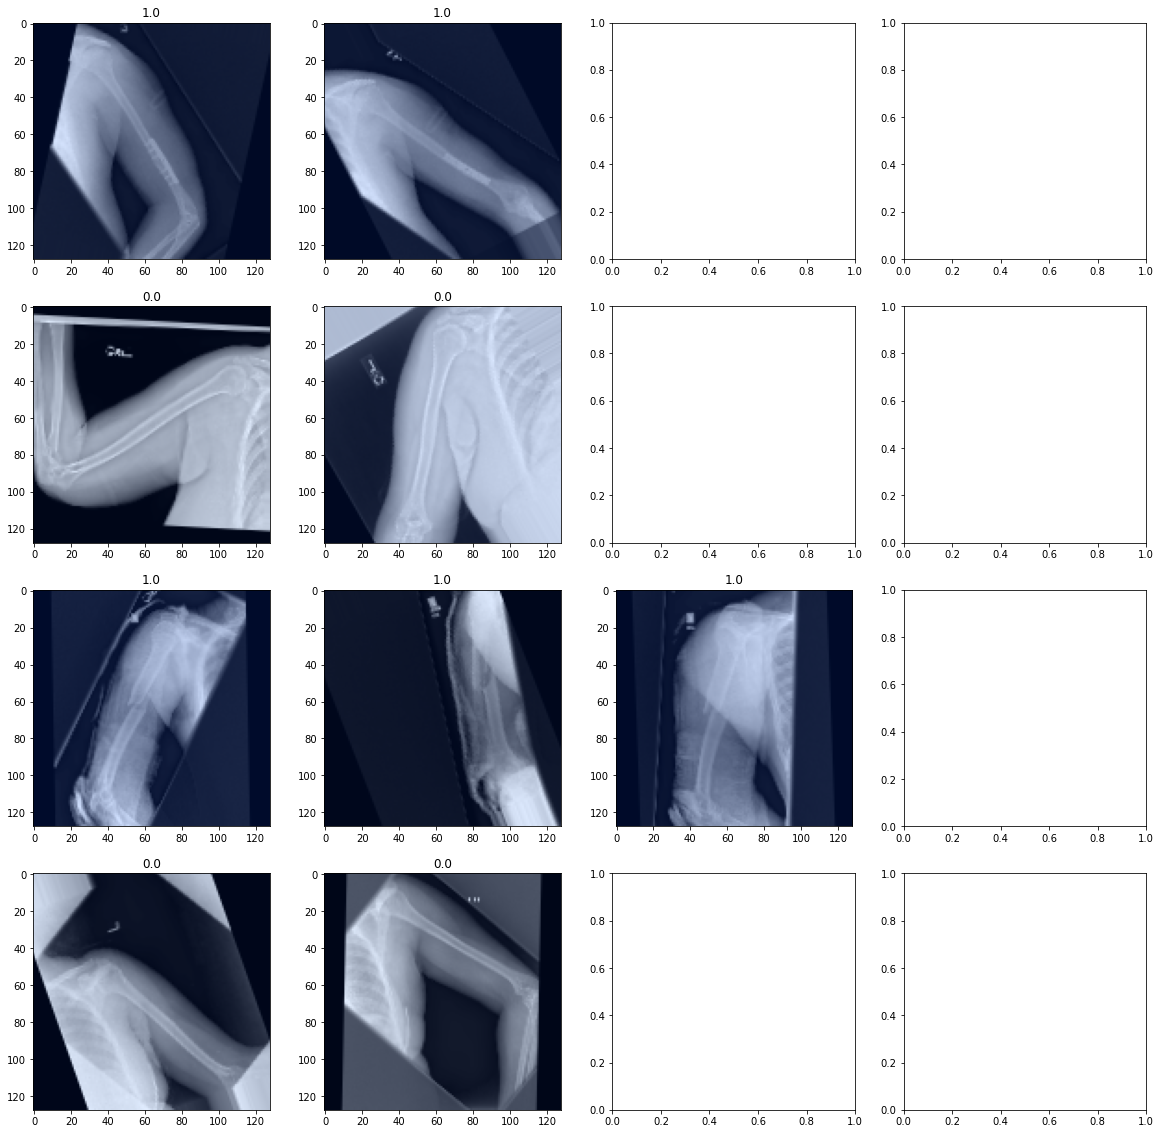

In [5]:
train_dc.show(figsize=(20,20))

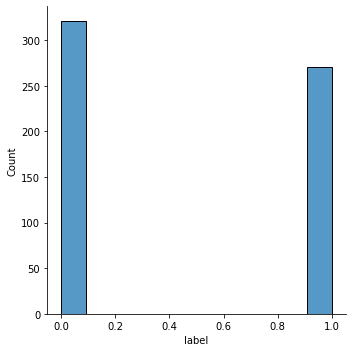

In [6]:
sb.displot(train_dc.df, x='label')

## Model

In [7]:
#from tensorflow.keras.applications import DenseNet169, DenseNet121
from dmv.dense import DenseNet121, dense_block
from tensorflow.keras.layers import Dense, TimeDistributed, Flatten, Dropout, Input, BatchNormalization, Reshape, Activation, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2

from dmv.layer import DynamicMultiViewRNN, DynamicMultiViewRNN2D

class DynamicMultiViewModel(Model):
    def __init__(self, num_classes, input_shape, alpha=0.0002):
        super().__init__()
        
        dense, inputs, intermediate, out = DenseNet121(include_top=False, input_shape=input_shape, pooling='avg')
        self.base = Model(inputs, intermediate, name='densenet_head')
        for layer in self.base.layers[:-30]:
            layer.trainable = False
        for layer in self.base.layers[-30:]:
            layer.trainable = True
        
        
        self.agg = DynamicMultiViewRNN()
        
        tail_input = Input(shape=(4, 4, 512))
        tail_x = dense_block(tail_input, 16, name='conv5')
        tail_x = BatchNormalization(axis=3, epsilon=1.001e-5, name='bn')(tail_x)
        tail_x = Activation('relu', name='relu')(tail_x)
        tail_x = GlobalAveragePooling2D(name='avg_pool')(tail_x)
        self.tail = Model(tail_input, tail_x, name='densenet_tail')
        
        for layer in self.tail.layers:
            if 'input' not in layer.name:
                dense_weights = dense.get_layer(layer.name).get_weights()
                layer.set_weights(dense_weights)
            
            layer.trainable = True
        
        self.batchnorm = BatchNormalization()
        self.dropout_1 = Dropout(.5)
        self.dense = Dense(10, activation='relu', name='dense')
        self.dropout = Dropout(.5)
        self.classify = Dense(num_classes, activation='sigmoid', name='classify')
        
        regularizer = l2(alpha / 2)
        for layer in self.base.layers + self.tail.layers + [self.classify]:
            for attr in ['kernel_regularizer', 'bias_regularizer']:
                if hasattr(layer, attr) and layer.trainable:
                    setattr(layer, attr, regularizer)
    
    def call(self, x):
        x = TimeDistributed(self.base)(x)
        x = TimeDistributed(Flatten())(x)
        x = self.agg(x)
        x = Reshape((4, 4, 512))(x)
        x = self.tail(x)
        
        x = self.batchnorm(x)
        x = self.dropout_1(x)
        x = self.dense(x)
        x = self.dropout(x)
        x = self.classify(x)

        return x

In [8]:
class SingleViewModel(Model):
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.base = DenseNet169(include_top=False, input_shape=input_shape, pooling='avg')
        for layer in self.base.layers:
            layer.trainable = True
        
        #self.dense = Dense(50, activation='relu', name='dense_after_flatten')
        #self.dropout = Dropout(.5)
        self.classify = Dense(num_classes, activation='sigmoid', name='classify')
    
    def call(self, x):
        x = self.base(x)
        #x = self.dropout(x)
        #x = self.dense(x)
        #x = self.dropout(x)
        x = self.classify(x)
        
        return x

## Instantiating

In [9]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

if multi:
    model = DynamicMultiViewModel(1, train_dc._output_shape[-3:])
    
    model.build(tuple([train_dc._batch_size] + train_dc._output_shape))
    model.compile(
        optimizer=Adam(0.00001, beta_1=0.9, beta_2=0.999),
        metrics=[
            'accuracy',
            tfa.metrics.CohenKappa(num_classes=2)
        ],
        loss=BinaryCrossentropy()
    )
else:
    model = SingleViewModel(1, train_dc._output_shape[-3:])
    
    model.build(tuple([train_dc._batch_size] + train_dc._output_shape))
    model.compile(
        optimizer=Adam(0.0001, beta_1=0.9, beta_2=0.999),
        metrics=[
            'accuracy',
            tfa.metrics.CohenKappa(num_classes=2)
        ],
        loss=BinaryCrossentropy()
    )
        
model.summary()

Model: "dynamic_multi_view_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet_head (Functional)   (None, 4, 4, 512)         4847168   
_________________________________________________________________
dynamic_multi_view_rnn (Dyna multiple                  0         
_________________________________________________________________
densenet_tail (Functional)   (None, 1024)              2190336   
_________________________________________________________________
batch_normalization (BatchNo multiple                  4096      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  10250     
_________________________________________________________________
dropout_1 (Dropout)          multiple     

## Callbacks

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

log_dir = os.path.join('D:\Files\logs\capita')
log_record_dir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_record_dir, histogram_freq=1)
print(f'Tensorboard logs available on: {log_dir}')

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

Tensorboard logs available on: D:\Files\logs\capita


## Training

In [11]:
class_weights = {
    0: len(train_dc.df[train_dc.df['label'] == 1]) / len(train_dc.df),
    1: len(train_dc.df[train_dc.df['label'] == 0]) / len(train_dc.df),
}

In [12]:
model.fit(
    x=train_dc.ds(),
    steps_per_epoch=train_dc.batches_per_epoch,
    validation_data=valid_dc.ds(),
    validation_steps=valid_dc.batches_per_epoch,
    epochs=50,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stop, reduce_lr]
)

Epoch 1/50
 1/74 [..............................] - ETA: 0s - loss: 0.7013 - accuracy: 0.2500 - cohen_kappa: -0.4118WARNING:tensorflow:From D:\Files\Documents\Anaconda\envs\capita\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
74/74 [==============================] - 19s 255ms/step - loss: 0.4490 - accuracy: 0.5186 - cohen_kappa: 0.0164 - val_loss: 0.6650 - val_accuracy: 0.5185 - val_cohen_kappa: 0.0301
Epoch 2/50
74/74 [==============================] - 12s 165ms/step - loss: 0.4089 - accuracy: 0.5845 - cohen_kappa: 0.1478 - val_loss: 0.6621 - val_accuracy: 0.5630 - val_cohen_kappa: 0.1202
Epoch 3/50
74/74 [==============================] - 11s 155ms/step - loss: 0.3826 - accuracy: 0.5760 - cohen_kappa: 0.1393 - val_loss: 0.6477 - val_accuracy: 0.5926 - val_cohen_kappa: 0.1802
Epoch 4/50
74/74 [=======